# Use-Case and Context

The European Centre for Medium-range Weather Forecasts (ECMWF) has developed a series of model giving the current best accurate parametrization scheme available—among those, SPARTACUS delivers **radiation** prediction over the globe. Because it is demanding in computations, a simpler, degraded model called TRIPLECLOUD is developed to satisfy the production environment constraints. 

**The task is to develop a model to learn and apply a bias correction term to TRIPLECLOUD.**

Like most climate models, to leverage hardware acceleration, the choice was made to split the globe in blocks—this has for consequence losing the spatial correlation for a gain in parallelization. The atomic block is a [column of data](https://brian-rose.github.io/ClimateLaboratoryBook/courseware/climate-system-models.html#introducing-the-gcm) that expresses physical values throughout the vertical dimension over a set of levels called the [*model levels*](https://confluence.ecmwf.int/display/UDOC/Model+level+definitions).

Finally, the earth is a huge sphere and sampling every square-inch is physically impossible. The mesh is a 'regular' grid of 25 km2, so the data for a single unit averages the values for that unit.

Now let's load the raw data we'll be using throughout the sessions. This notebook is largely inspired from [the work from ECMWF](https://git.ecmwf.int/projects/MLFET/repos/maelstrom-radiation/browse/climetlab_maelstrom_radiation/radiation.py) on the radiation use-case.

First things first. Remember `this`.

In [1]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


## Exploring a sample

### Variables

Each columnar block has a series of variables that reflect physical values such as **Albedo, Temperature, Pressure, Humidity**... Plus some variables that describe the **anatomy of the surface**. We will not cover them all, but only a selection of it so you get a sense of what they represent.

In [2]:
from kosmoss import ARTIFACTS_PATH, CACHED_DATA_PATH

In [3]:
import os.path as osp
import climetlab as cml
import matplotlib.pyplot as plt
import numpy as np 

SCA variables ?

In [4]:
sca_var_keys = [
    'skin_temperature', 
    'cos_solar_zenith_angle',
    'sw_albedo_band_0',
    'sw_albedo_band_1',
    'sw_albedo_band_2',
    'sw_albedo_band_3',
    'sw_albedo_band_4',
    'sw_albedo_band_5',
    'sw_albedo_direct_band_0',
    'sw_albedo_direct_band_1',
    'sw_albedo_direct_band_2',
    'sw_albedo_direct_band_3',
    'sw_albedo_direct_band_4',
    'sw_albedo_direct_band_5',
    'lw_emissivity_band_0',
    'lw_emissivity_band_1',
    'solar_irradiance'
]

COL variables?

In [5]:
col_var_keys = [
    'q', 
    'o3_mmr', 
    'co2_vmr', 
    'n2o_vmr', 
    'ch4_vmr', 
    'o2_vmr', 
    'cfc11_vmr', 
    'cfc12_vmr', 
    'hcfc22_vmr', 
    'ccl4_vmr', 
    'cloud_fraction',
    'aerosol_mmr_0',
    'aerosol_mmr_1',
    'aerosol_mmr_2',
    'aerosol_mmr_3',
    'aerosol_mmr_4',
    'aerosol_mmr_5',
    'aerosol_mmr_6',
    'aerosol_mmr_7',
    'aerosol_mmr_8',
    'aerosol_mmr_9',
    'aerosol_mmr_10',
    'aerosol_mmr_11',
    'q_liquid', 
    'q_ice', 
    're_liquid', 
    're_ice'
]

HL variables, INTER variables?

In [6]:
hl_var_keys = [
    'temperature_hl', 
    'pressure_hl'
]
inter_var_key = [
    'overlap_param'
]

### Defining the plotters

We use Matplotlib to quickly produce the graphs for UC understanding purposes.

In [7]:
def plot_sca(field: np.ndarray, idx: int) -> None:
    
    print(idx, sca_var_keys[idx])
    
    xmean, xstd = field.mean(), field.std()
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.hist(field, 
            bins=150, 
            histtype="step", 
            density=True)
    
    ax.set_title('{}'.format(sca_var_keys[idx]))
    
    textstr = '\n'.join((
        r'$\mu=%.2f$' % (xmean,),
        r'$\sigma=%.2f$' % (xstd,)
    ))
    
    ax.text(0.75, 
            0.95, 
            textstr, 
            transform=ax.transAxes, 
            fontsize=10,
            verticalalignment='top')
    
    path = osp.join(ARTIFACTS_PATH, f'hist-scalar-var-{sca_var_keys[idx]}')
    plt.savefig(path)
    plt.show()

In [8]:
def plot_col(field: np.ndarray, idx: int, var_names: list) -> None:
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 8))
    
    # Histogram
    xmean, xstd = field.mean(), field.std()
    print(xmean, xstd)
    ax[0].hist(field.flatten(), 
               bins=150, 
               histtype="step", 
               density=True)
    
    textstr = '\n'.join((
        r'$\mu=%.3e$' % (xmean,),
        r'$\sigma=%.3e$' % (xstd,)
    ))
    ax[0].text(0.5, 
               0.95, 
               textstr, 
               transform=ax[0].transAxes, 
               fontsize=14,
               verticalalignment='top')
    
    # vertical profile of mean variable
    ax[1].plot(field.mean(axis=0), np.arange(field.shape[1]))
    ax[1].invert_yaxis()
    
    # vertical profile of std variable
    ax[2].plot(field.std(axis=0), np.arange(field.shape[1]))
    ax[2].invert_yaxis()
    
    fig.suptitle('{}'.format(var_names[idx]), fontsize=16)
    path = osp.join(ARTIFACTS_PATH, f'fig-var-{var_names[idx]}')
    plt.savefig(path)
    plt.show()

In [9]:
def plot_output(field: np.ndarray, name: str) -> None:
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 8))
    
    # histogram
    xmean, xstd = field.mean(), field.std()
    print(xmean, xstd)
    ax[0].hist(field.flatten(), 
               bins=150, 
               histtype="step", 
               density=True)
    
    textstr = '\n'.join((
        r'$\mu=%.3e$' % (xmean,),
        r'$\sigma=%.3e$' % (xstd,)
    ))
    ax[0].text(0.5, 
               0.95, 
               textstr, 
               transform=ax[0].transAxes, 
               fontsize=14,
               verticalalignment='top')
    
    # vertical profile of mean variable
    ax[1].plot(field.mean(axis=0), np.arange(field.shape[1]))
    ax[1].invert_yaxis()
    
    # vertical profile of std variable
    ax[2].plot(field.std(axis=0), np.arange(field.shape[1]))
    ax[2].invert_yaxis()
    
    fig.suptitle('{}'.format(name), fontsize=16)
    path = osp.join(ARTIFACTS_PATH, f'fig-var-{name}')
    plt.savefig(path)
    plt.show()

## The raw dataset

Don't mind this, we'll explain later, next notebook...

In [10]:
print(CACHED_DATA_PATH)

/root/.kosmoss/data/cached


In [11]:
cml.settings.set("cache-directory", CACHED_DATA_PATH)
cmlds = cml.load_dataset(
        'maelstrom-radiation',
        dataset='3dcorrection',
        date=20200101,
        timestep=[0],
        patch=list(range(0, 16)),
        raw_inputs=False,
    )

By downloading data from this dataset, you agree to the terms and conditions defined at https://apps.ecmwf.int/datasets/licences/general/ If you do not agree with such terms, do not download the data. 


In [12]:
cmlds.dataset_tags

{'mcica': 'rad4NN_outputs',
 '3dcorrection': '3dcorrection_outputs',
 'tripleclouds': 'triplecloud_outputs',
 'spartacus': 'spartacus_outputs'}

In [13]:
print(cmlds.isca_keys)
print(cmlds.icol_keys)
print(cmlds.ihl_keys)
print(cmlds.iinter_keys)

['skin_temperature', 'cos_solar_zenith_angle', 'sw_albedo', 'sw_albedo_direct', 'lw_emissivity', 'solar_irradiance']
['q', 'o3_mmr', 'co2_vmr', 'n2o_vmr', 'ch4_vmr', 'o2_vmr', 'cfc11_vmr', 'cfc12_vmr', 'hcfc22_vmr', 'ccl4_vmr', 'cloud_fraction', 'aerosol_mmr', 'q_liquid', 'q_ice', 're_liquid', 're_ice']
['temperature_hl', 'pressure_hl']
['overlap_param']


In [14]:
ds = cmlds.to_xarray()

In [15]:
ds

<xarray.Dataset>
Dimensions:       (column: 271360, sca_variable: 17, level: 137,
                   col_variable: 27, half_level: 138, hl_variable: 2,
                   p_variable: 1, level_interface: 136, inter_variable: 1)
Dimensions without coordinates: column, sca_variable, level, col_variable,
                                half_level, hl_variable, p_variable,
                                level_interface, inter_variable
Data variables: (12/13)
    sca_inputs    (column, sca_variable) float32 dask.array<chunksize=(16960, 1), meta=np.ndarray>
    col_inputs    (column, level, col_variable) float32 dask.array<chunksize=(16960, 137, 1), meta=np.ndarray>
    hl_inputs     (column, half_level, hl_variable) float32 dask.array<chunksize=(16960, 138, 1), meta=np.ndarray>
    pressure_hl   (column, half_level, p_variable) float32 dask.array<chunksize=(16960, 138, 1), meta=np.ndarray>
    inter_inputs  (column, level_interface, inter_variable) float32 dask.array<chunksize=(16960, 136, 1), meta=np.ndarray>
    lat           (column) float32 dask.array<chunksize=(16960,), meta=np.ndarray>
    ...            ...
    flux_dn_sw    (column, half_level) float32 dask.array<chunksize=(16960, 138), meta=np.ndarray>
    flux_up_sw    (column, half_level) float32 dask.array<chunksize=(16960, 138), meta=np.ndarray>
    flux_dn_lw    (column, half_level) float32 dask.array<chunksize=(16960, 138), meta=np.ndarray>
    flux_up_lw    (column, half_level) float32 dask.array<chunksize=(16960, 138), meta=np.ndarray>
    hr_sw         (column, level) float32 dask.array<chunksize=(16960, 137), meta=np.ndarray>
    hr_lw         (column, level) float32 dask.array<chunksize=(16960, 137), meta=np.ndarray>

In [16]:
ds.dims.get('col_variable')

27

### Plotting the Physical values

Finally, let's plot:
1. The histogram for each Sca variable
2. The values per model-level

0 skin_temperature


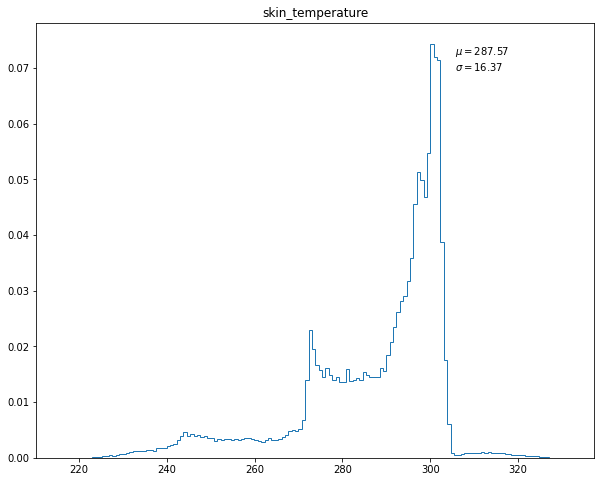

1 cos_solar_zenith_angle


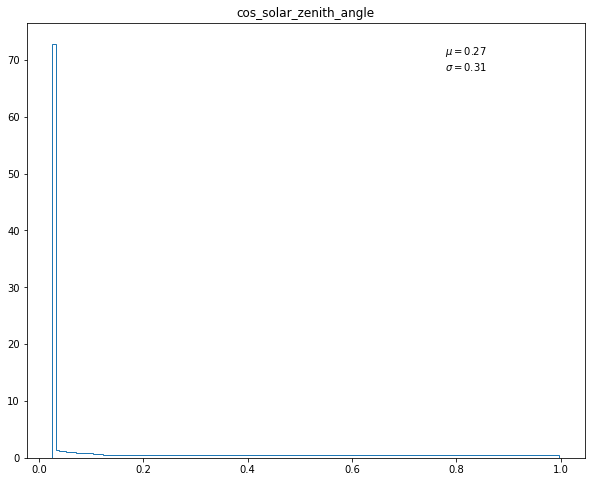

2 sw_albedo_band_0


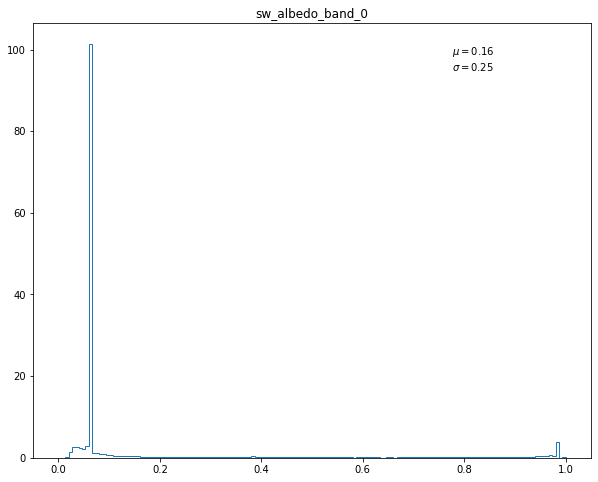

3 sw_albedo_band_1


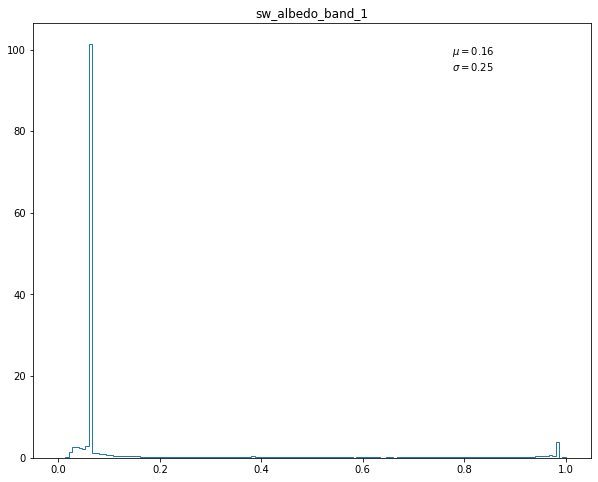

4 sw_albedo_band_2


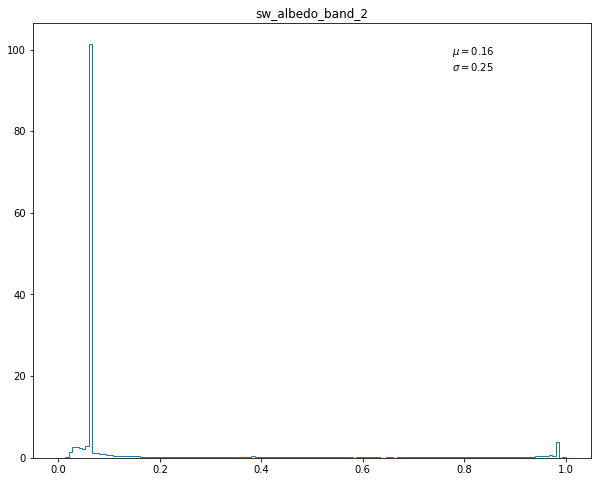

5 sw_albedo_band_3


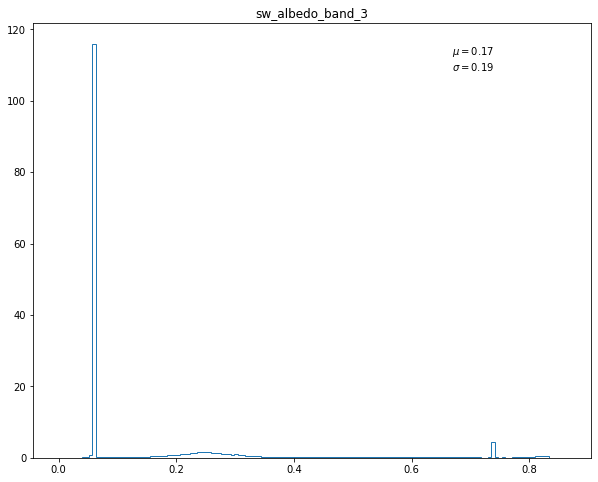

6 sw_albedo_band_4


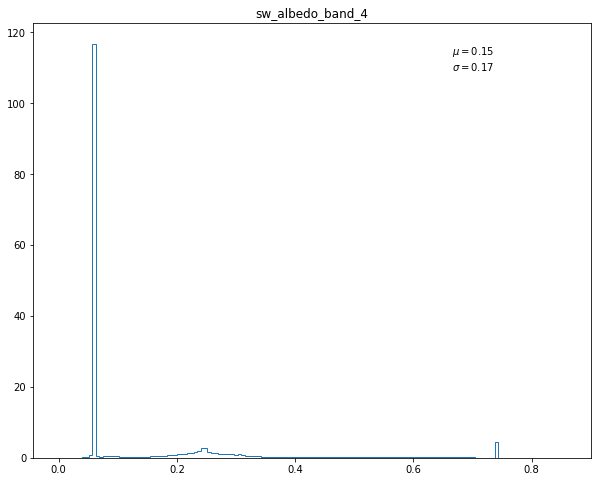

7 sw_albedo_band_5


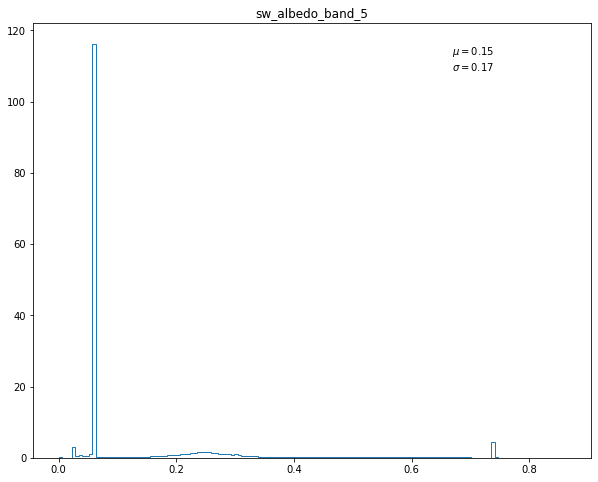

8 sw_albedo_direct_band_0


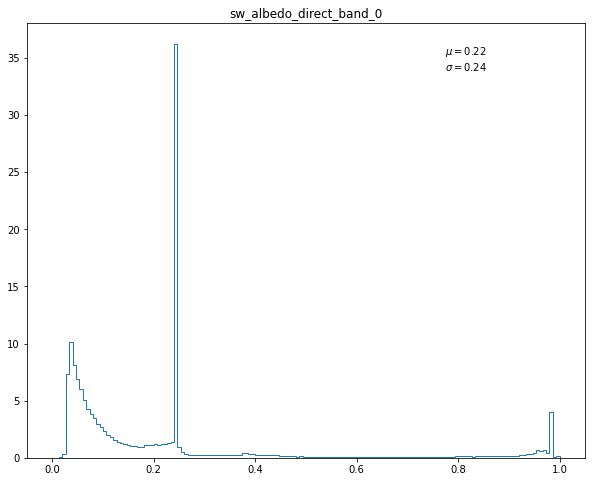

9 sw_albedo_direct_band_1


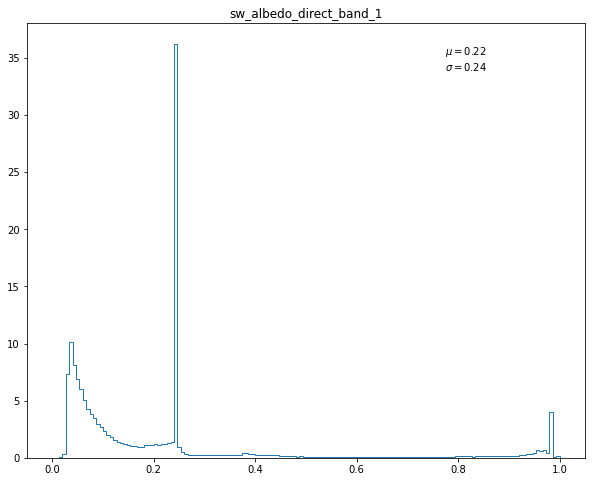

10 sw_albedo_direct_band_2


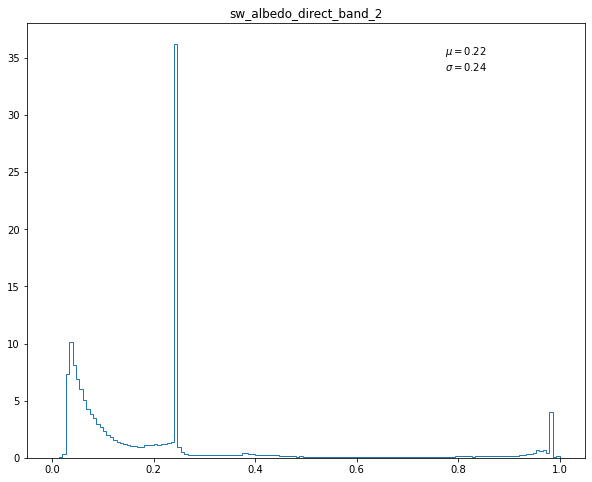

11 sw_albedo_direct_band_3


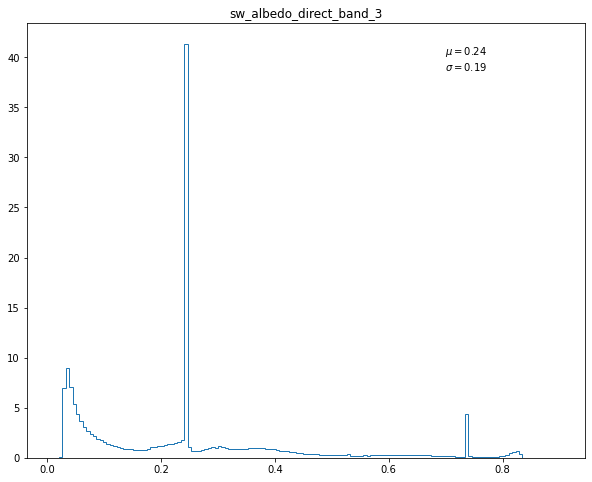

12 sw_albedo_direct_band_4


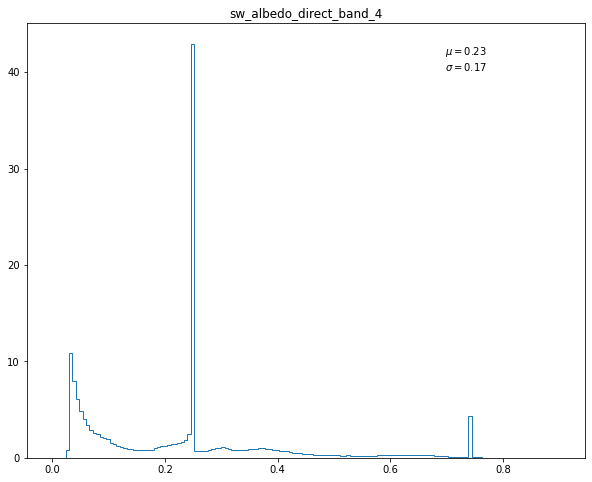

13 sw_albedo_direct_band_5


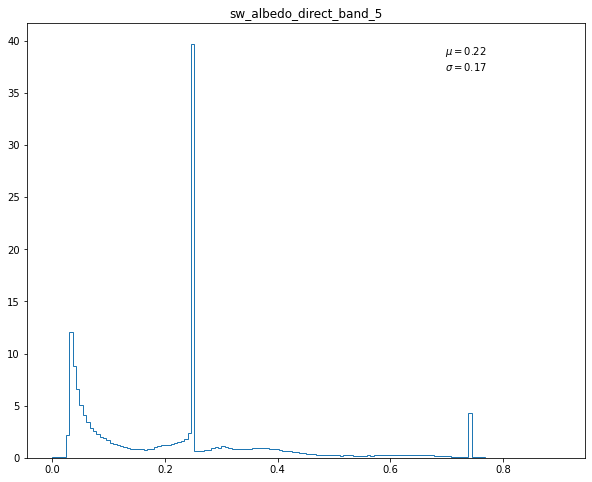

14 lw_emissivity_band_0


/usr/local/lib/python3.8/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.8/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


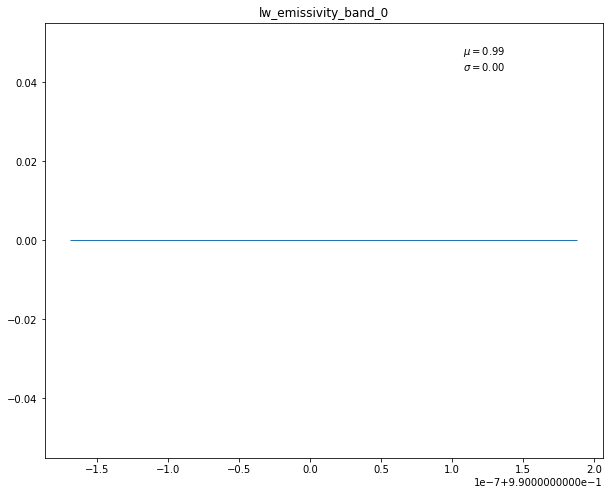

15 lw_emissivity_band_1


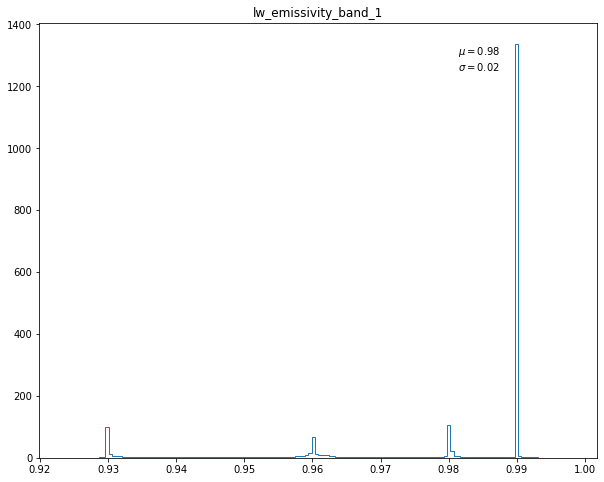

16 solar_irradiance


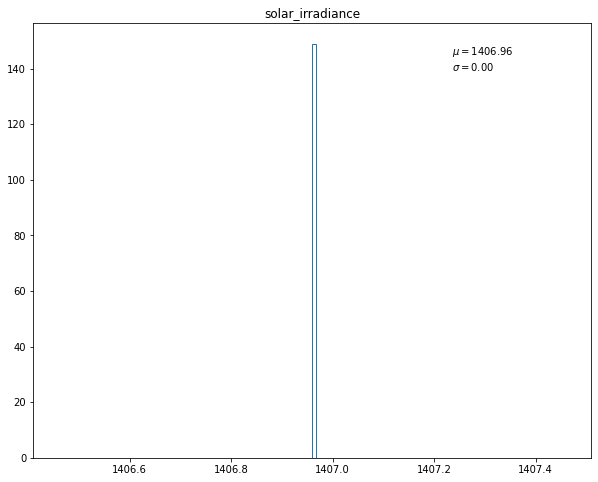

In [17]:
for i in range(ds.dims.get('sca_variable')):
    plot_sca(ds.sca_inputs[:, i], i)

Already, from a subset of the dataset, we see that:
* Amplitudes are very different and will require normalization
* Some of the variables seem useless, so we'll ditch them from the model
* Some seem extremely correlated and redundant
* Most are mostly uniform at the exception of a few values

**The use-case is a bias correction model, so we expect the amplitudes to be quite low, including the stats (mean and variance).**

0.0020084355 0.004230878


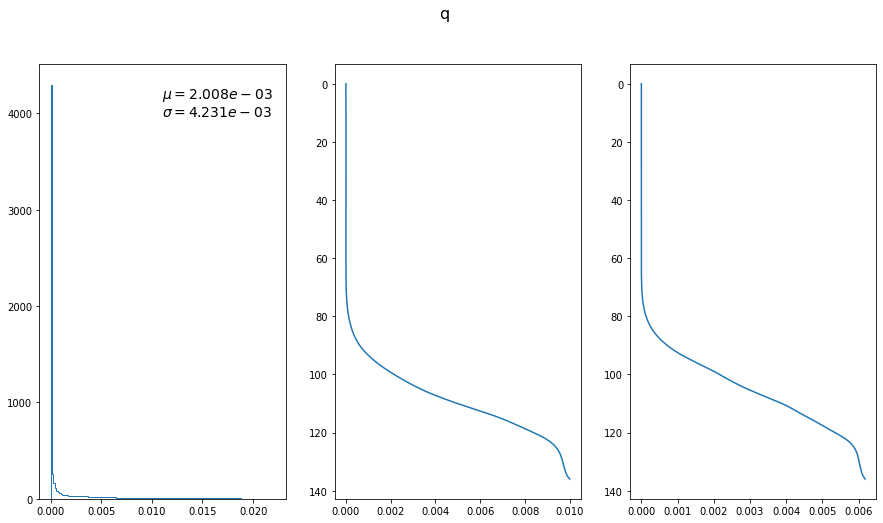

2.7773292e-06 4.3314317e-06


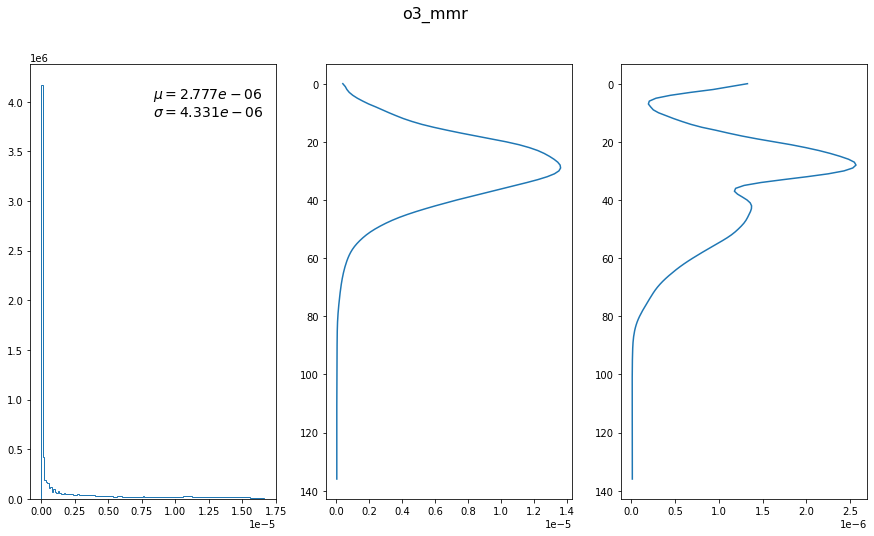

0.00040748843 4.6739365e-06


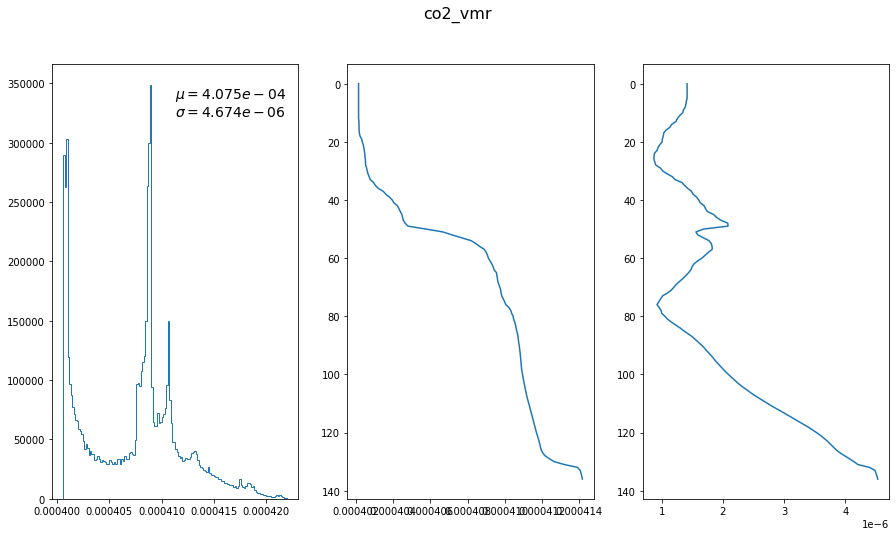

2.8986386e-07 7.4998496e-08


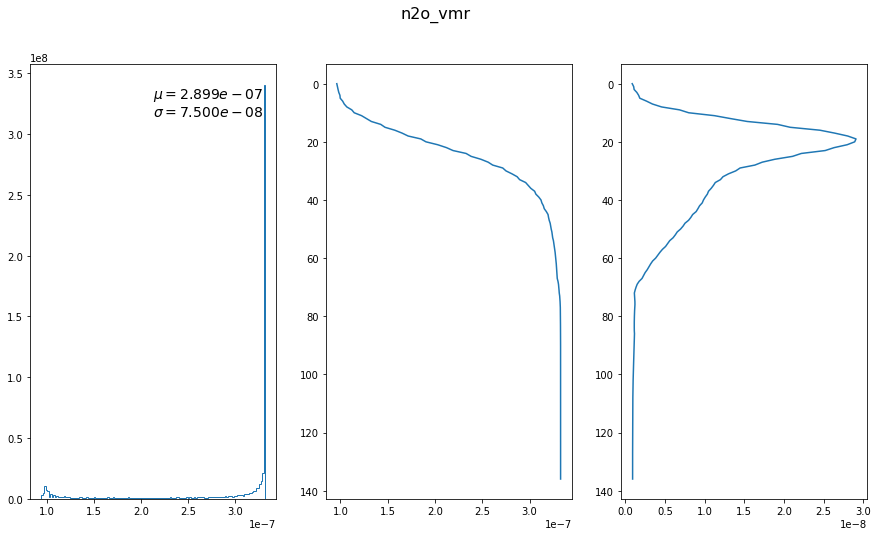

1.5279155e-06 5.615965e-07


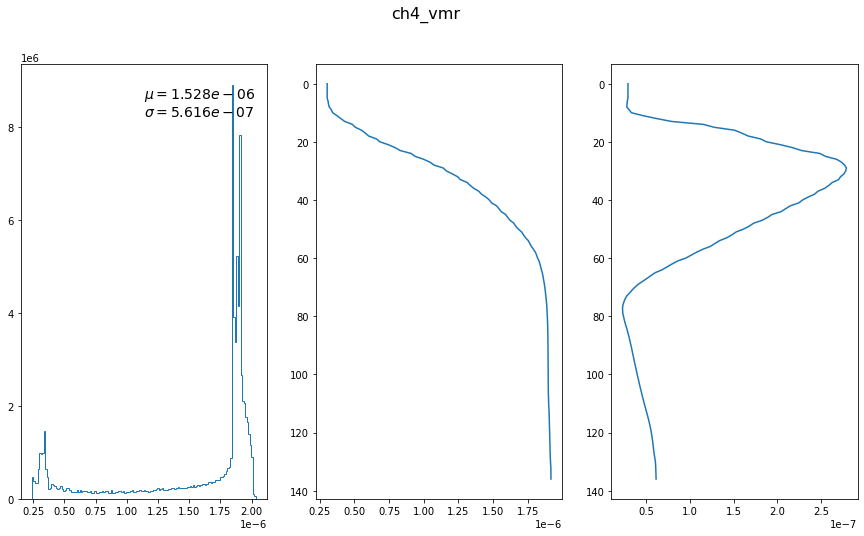

0.20942786 1.2114812e-05


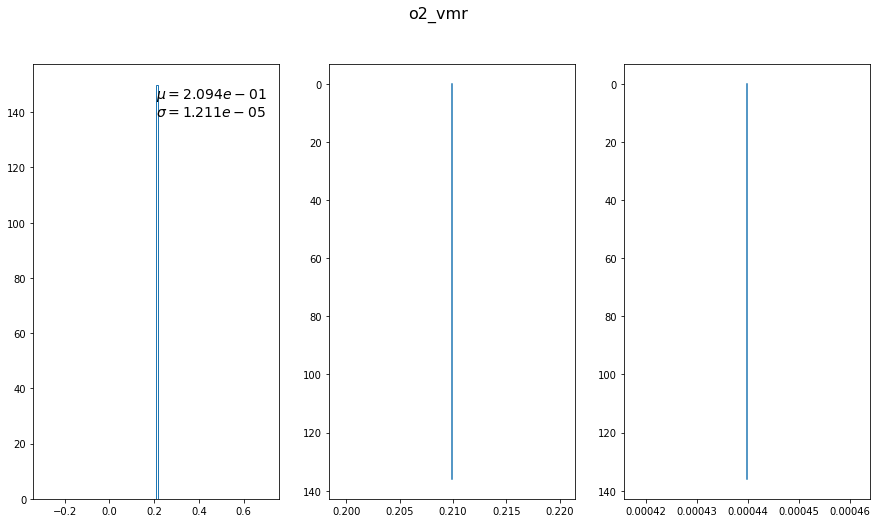

5.773785e-10 3.6164188e-10


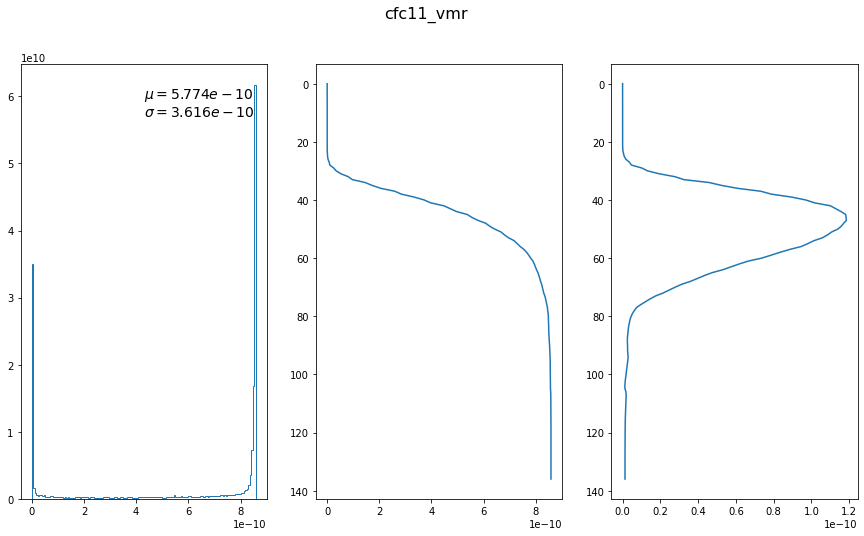

3.640801e-10 1.9482703e-10


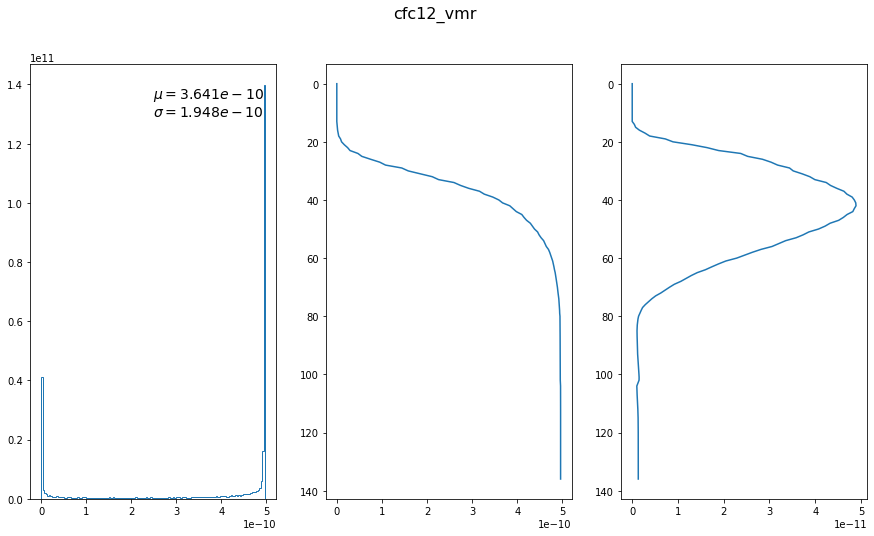

0.0 0.0


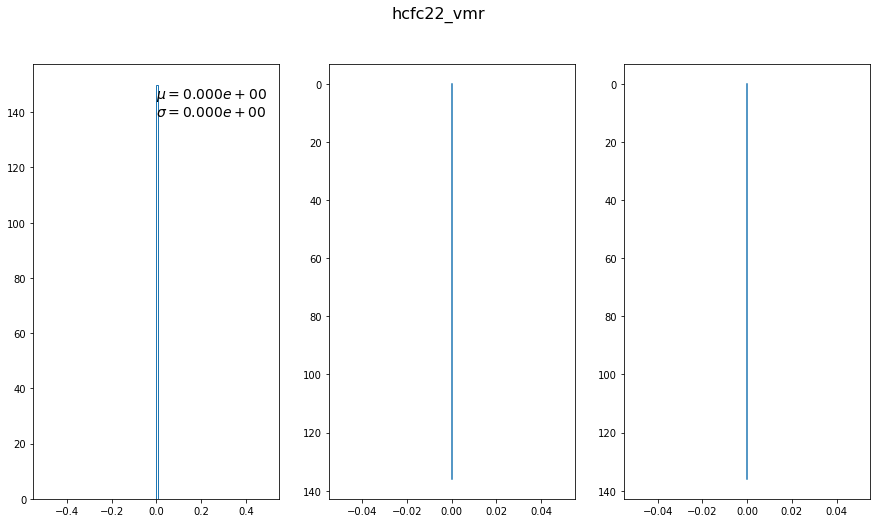

0.0 0.0


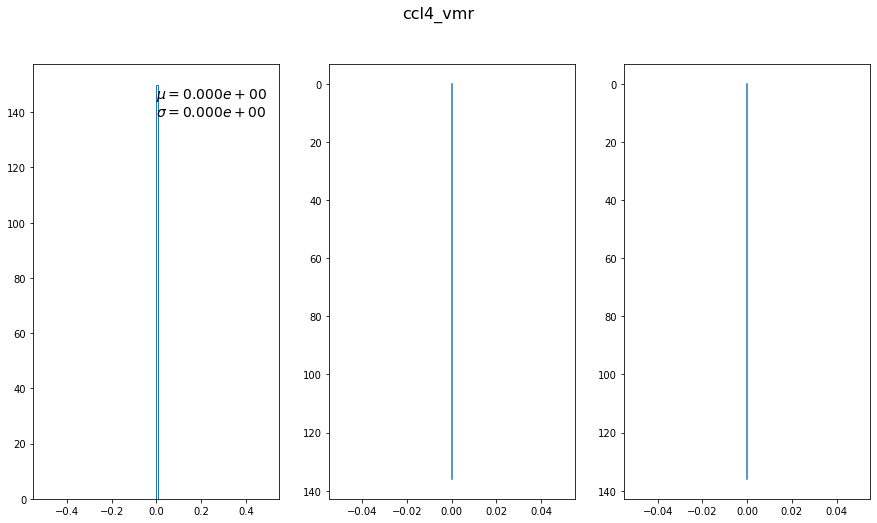

0.04256759 0.16292073


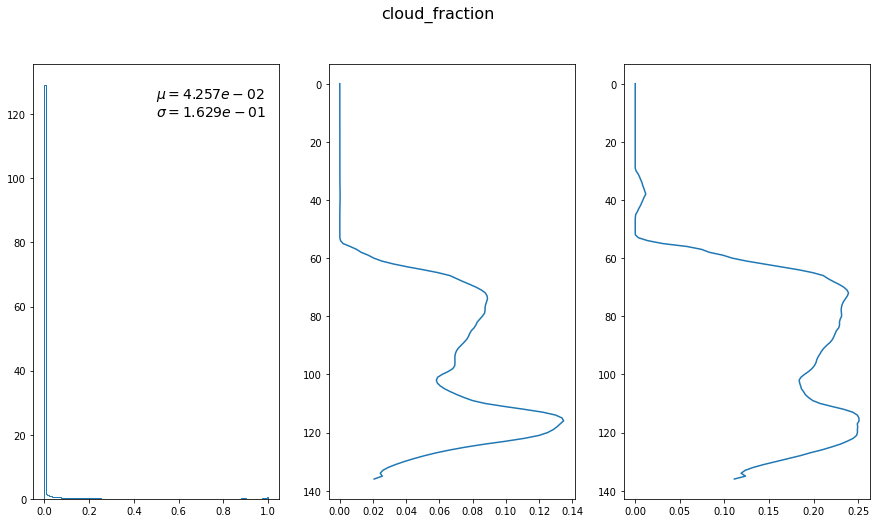

2.9370584e-10 4.441925e-10


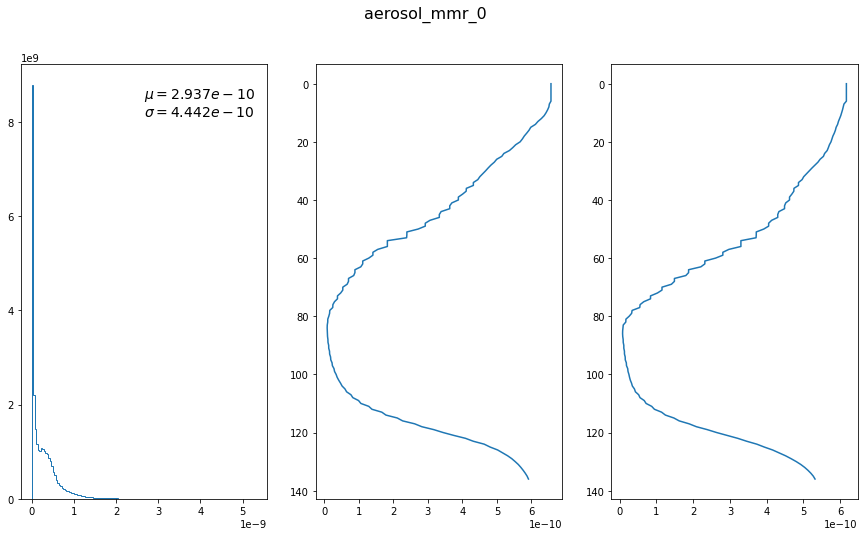

7.2687003e-09 1.9991628e-08


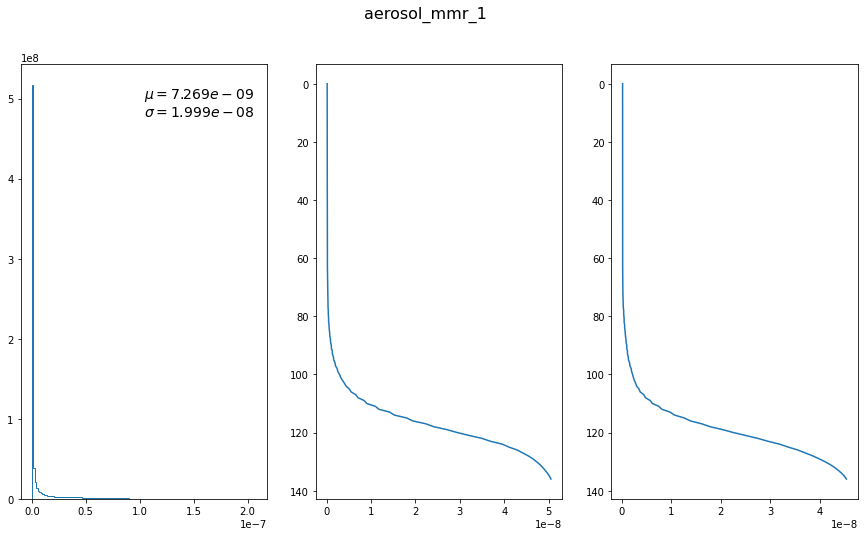

8.807062e-09 2.4287678e-08


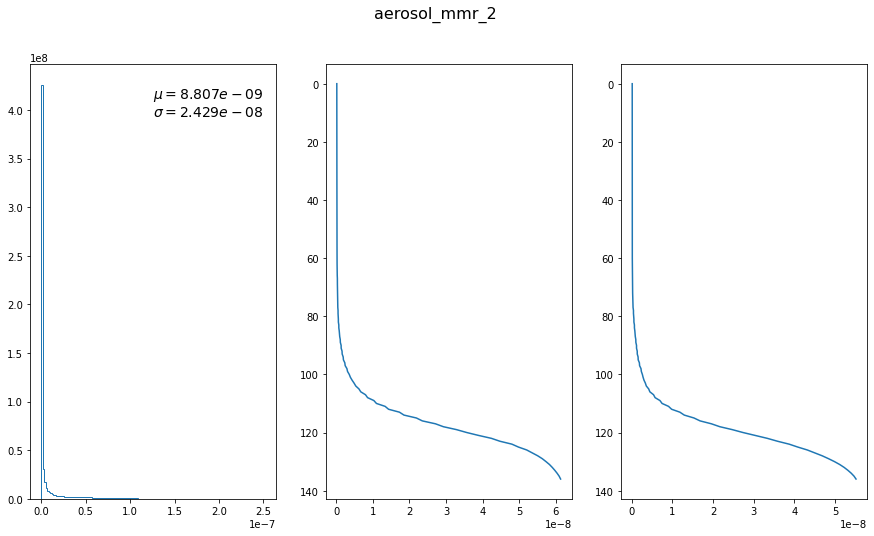

6.5870537e-10 1.9632216e-09


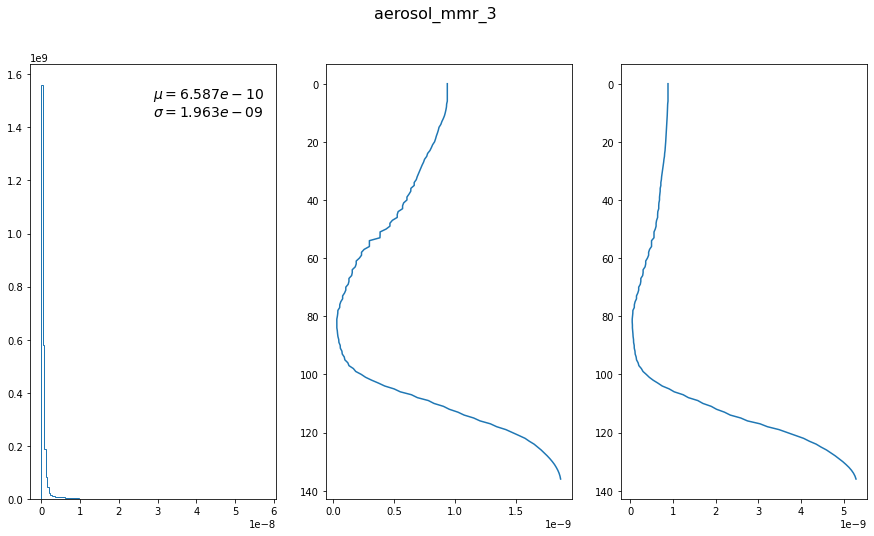

1.0601962e-09 5.856191e-09


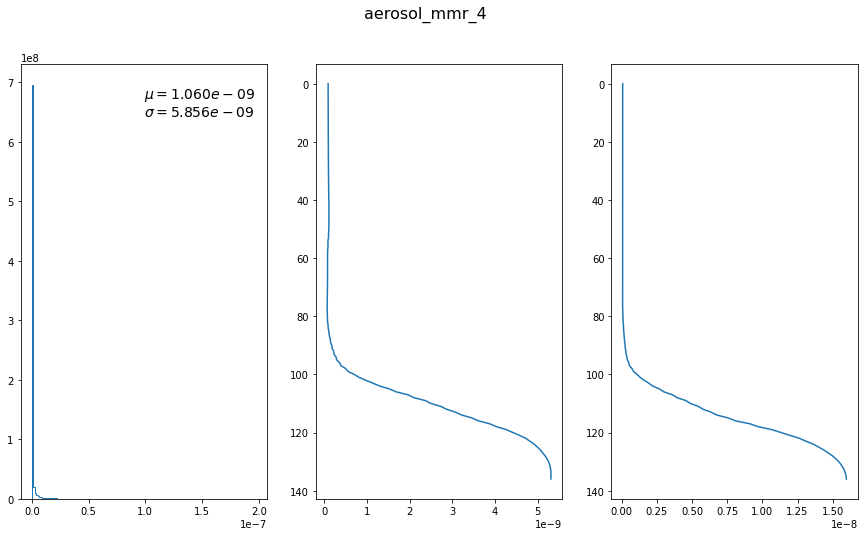

9.2518376e-10 5.8767022e-09


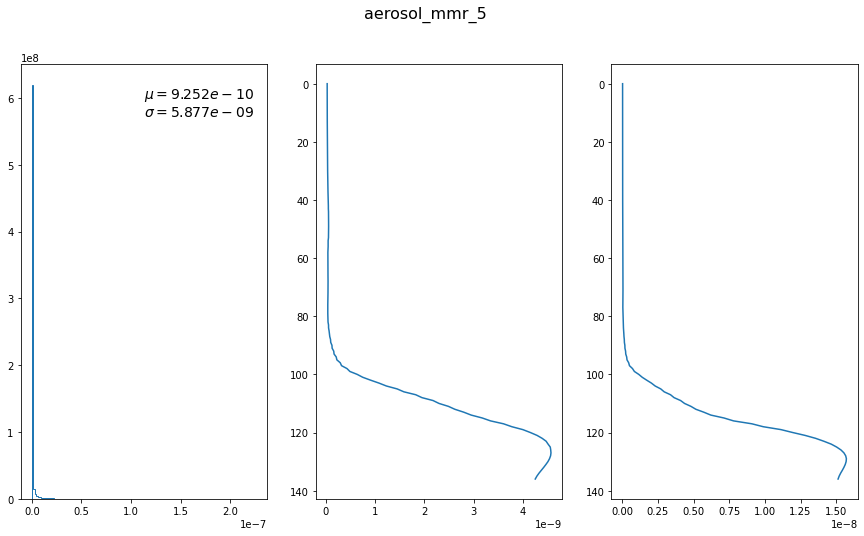

2.647083e-10 1.1278003e-09


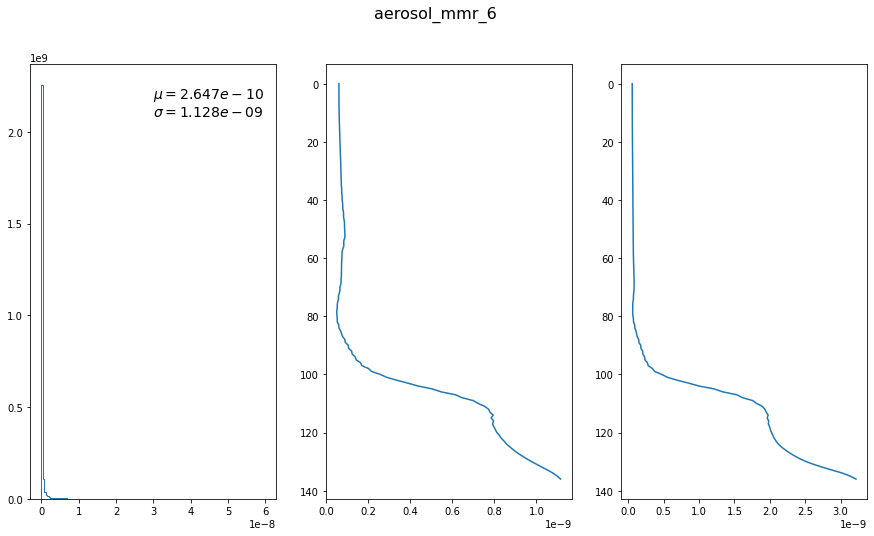

9.865068e-10 9.614514e-10


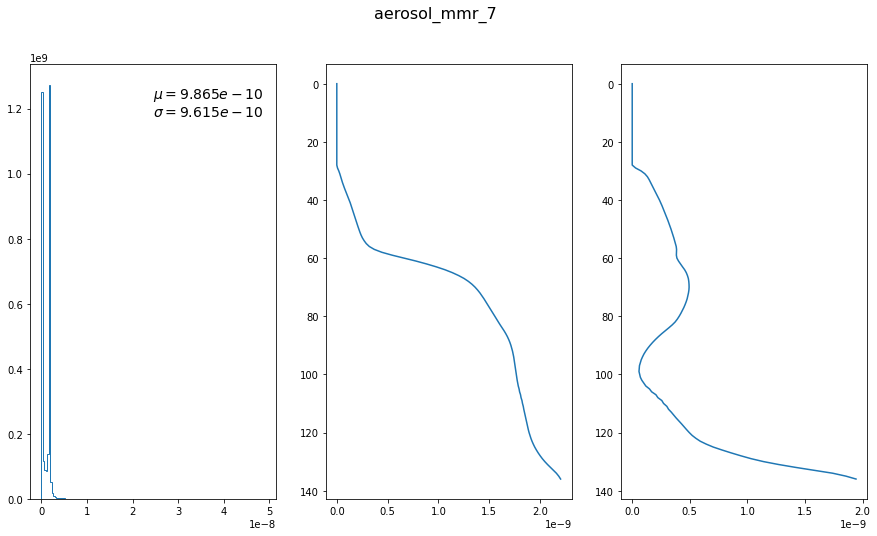

2.8769844e-11 1.230833e-10


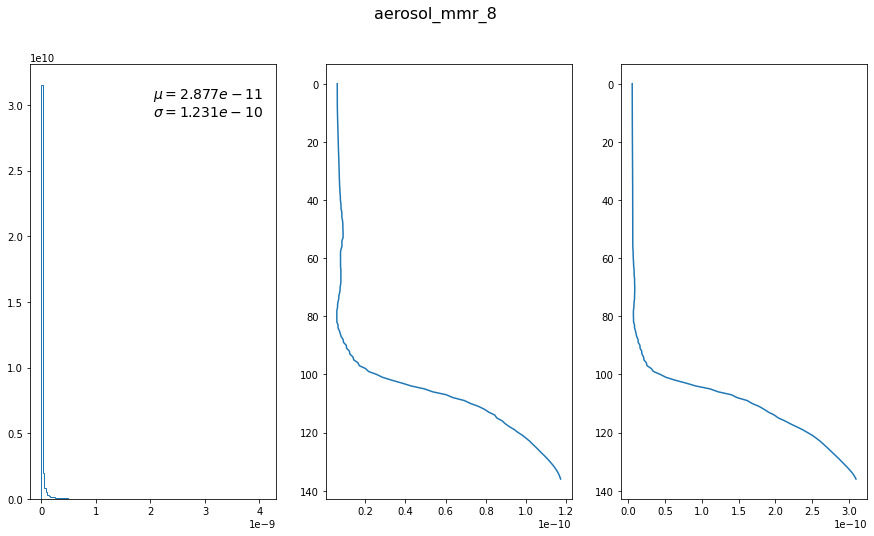

1.0109661e-11 1.006459e-10


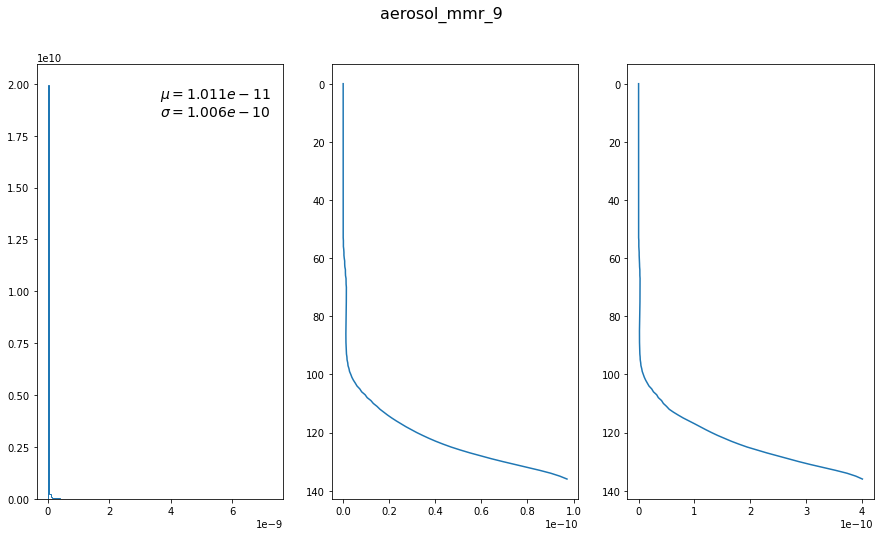

2.418411e-10 6.4568473e-10


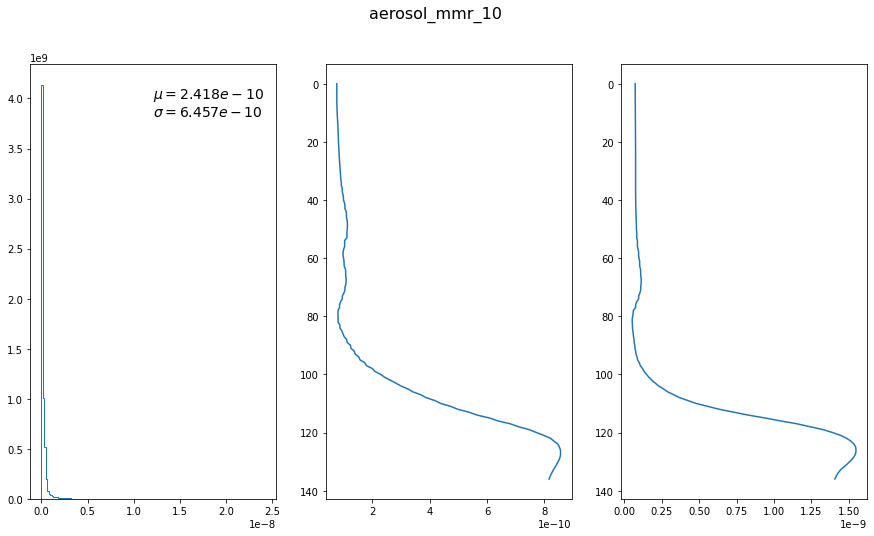

2.202923e-10 2.1946364e-10


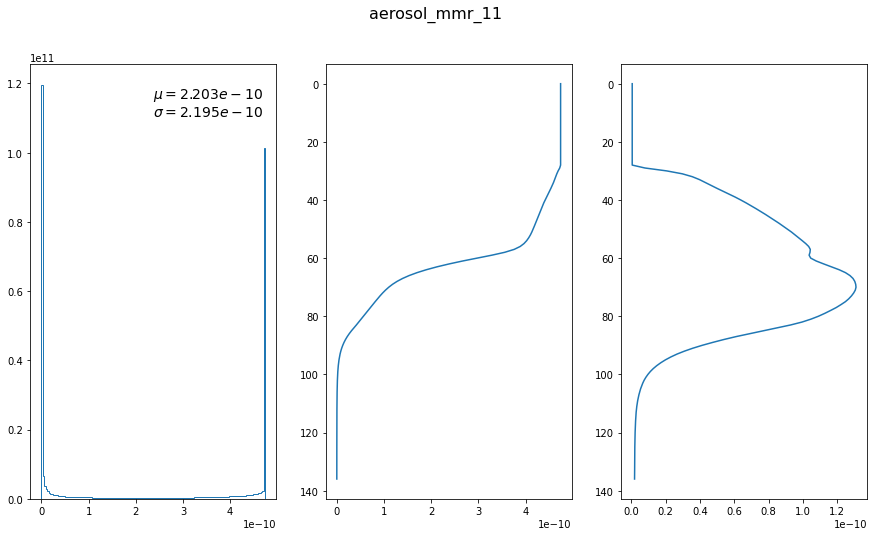

3.031041e-06 2.023258e-05


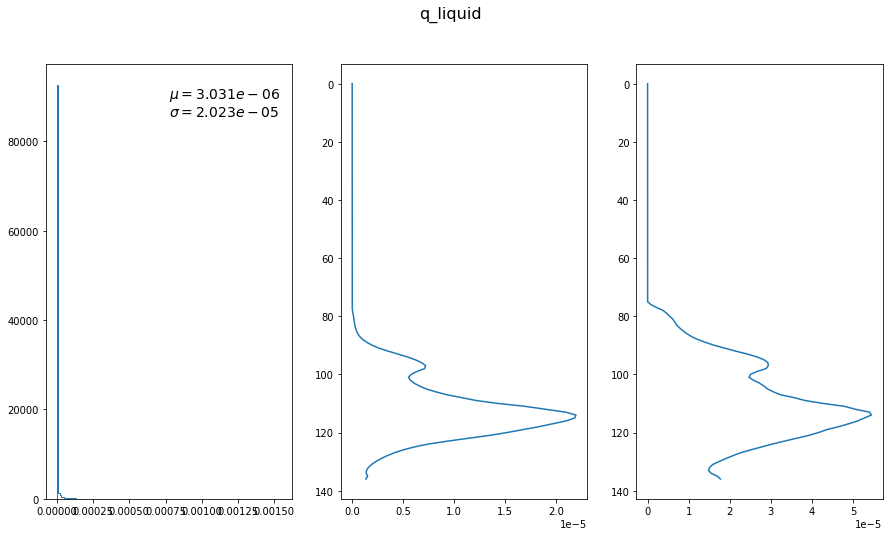

3.5943194e-06 4.5262237e-05


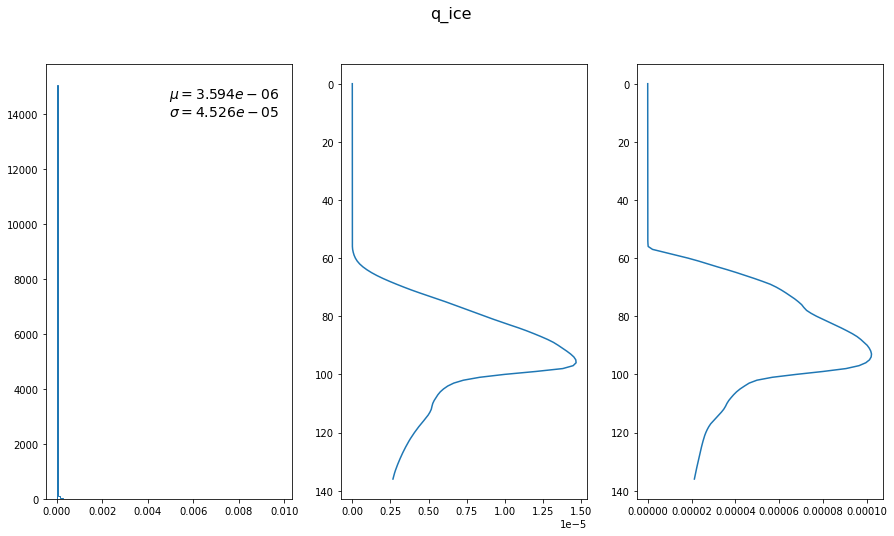

4.7980166e-06 3.2451428e-06


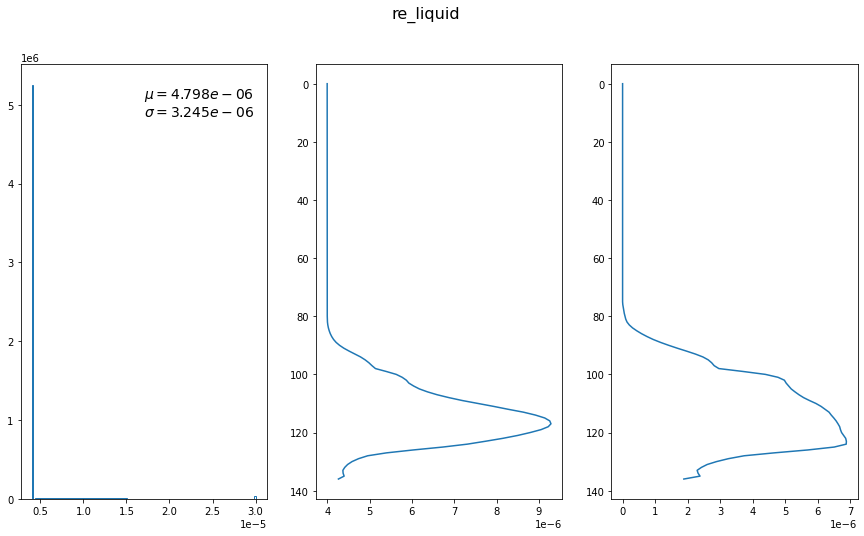

5.2193558e-05 7.275336e-06


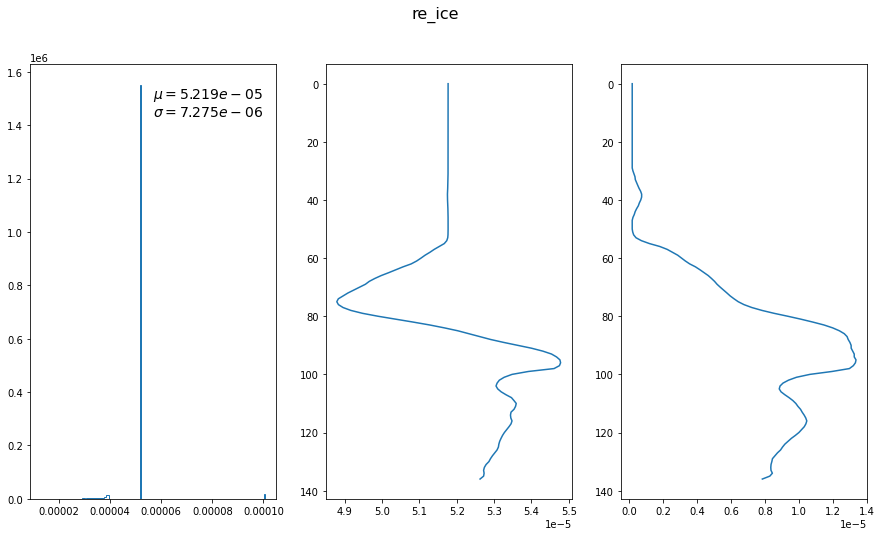

In [18]:
for i in range(ds.dims.get('col_variable')):
    plot_col(np.array(ds.col_inputs[:, :, i]), i, col_var_keys)

243.00911 30.463903


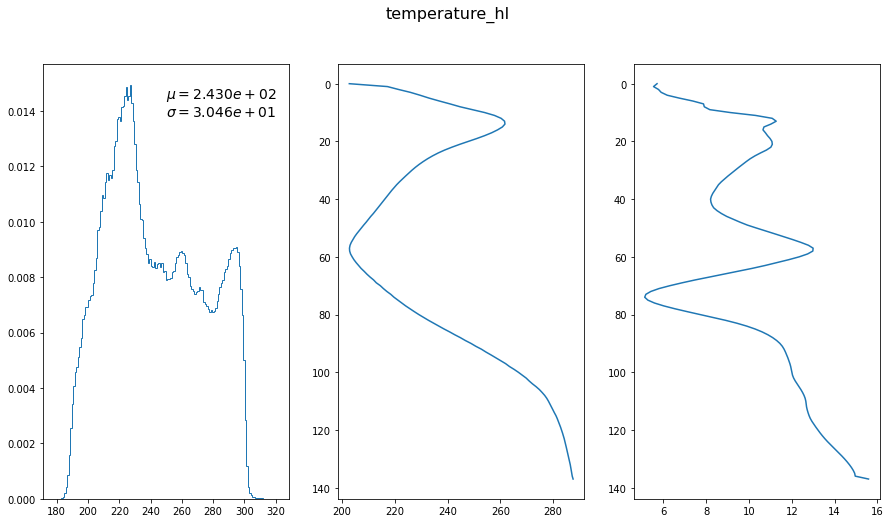

32719.107 35587.99


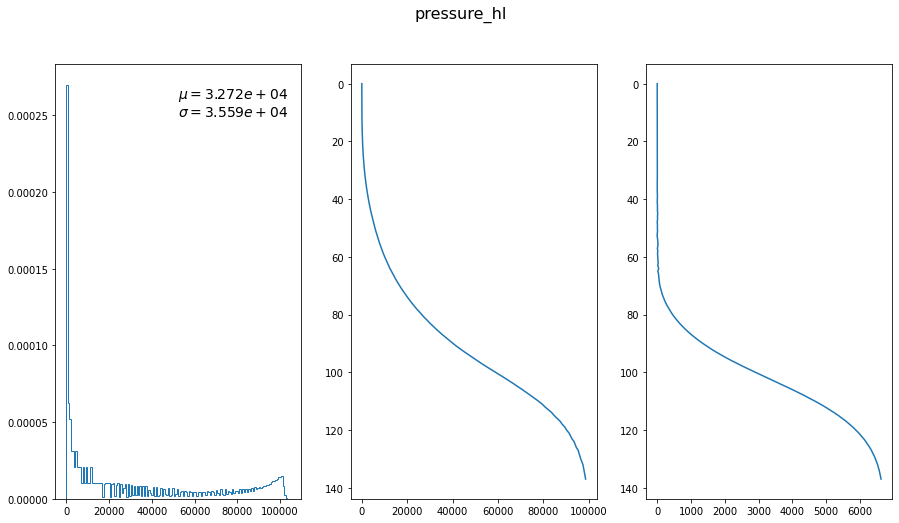

In [19]:
for i in range(ds.dims.get('hl_variable')):
    plot_col(np.array(ds.hl_inputs[:, :, i]), i, hl_var_keys)

0.79254884 0.19064368


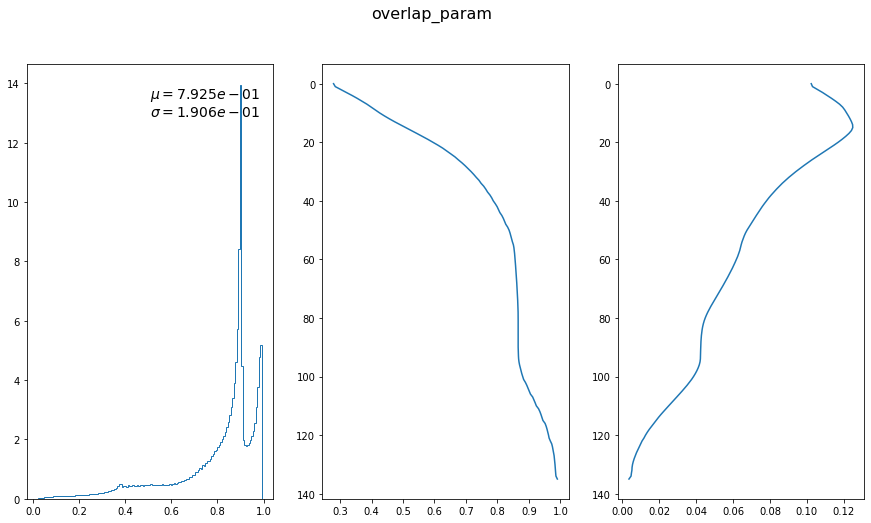

In [20]:
i = 0
plot_col(np.array(ds.inter_inputs[:, :, i]), i, inter_var_key)

0.36624703 0.8720312


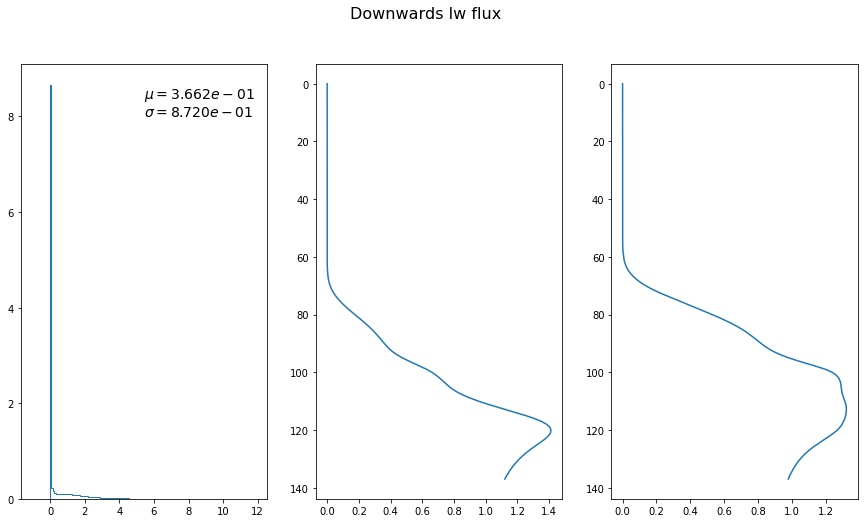

-0.6855834 1.0131058


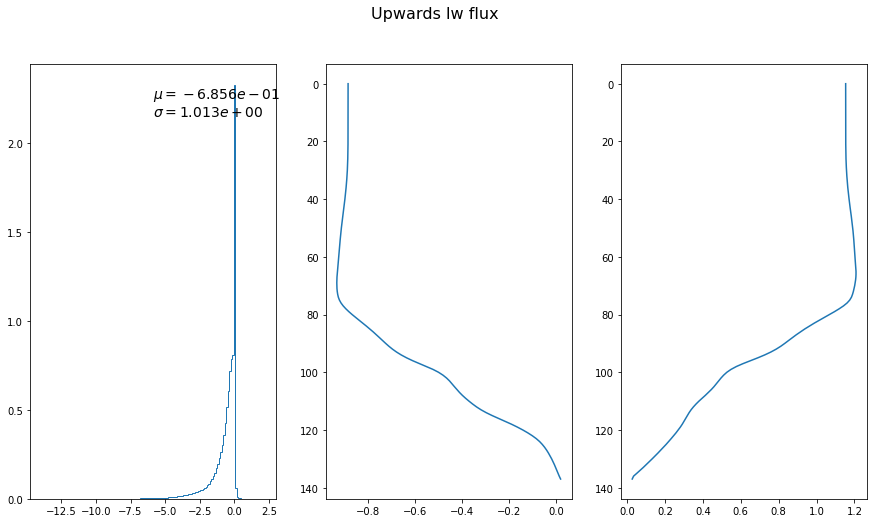

0.004629625 1.6057023


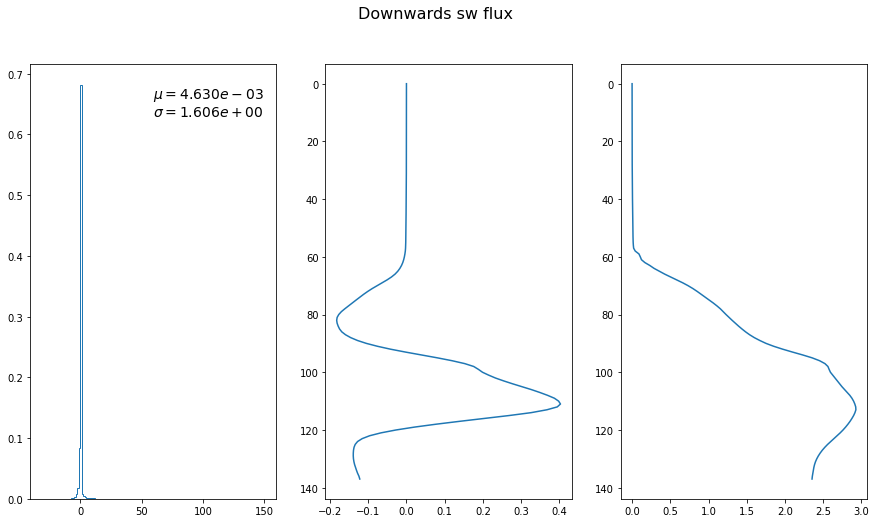

-0.6855834 1.0131058


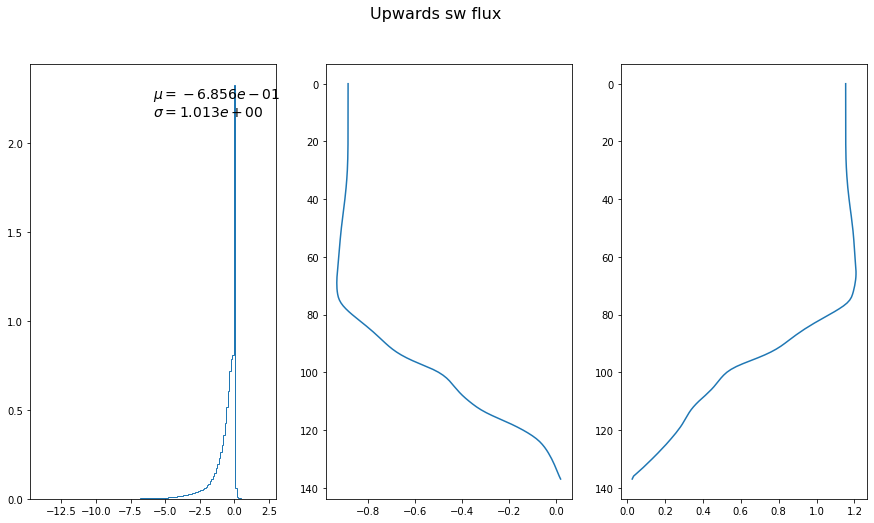

2.2440126e-08 6.583219e-07


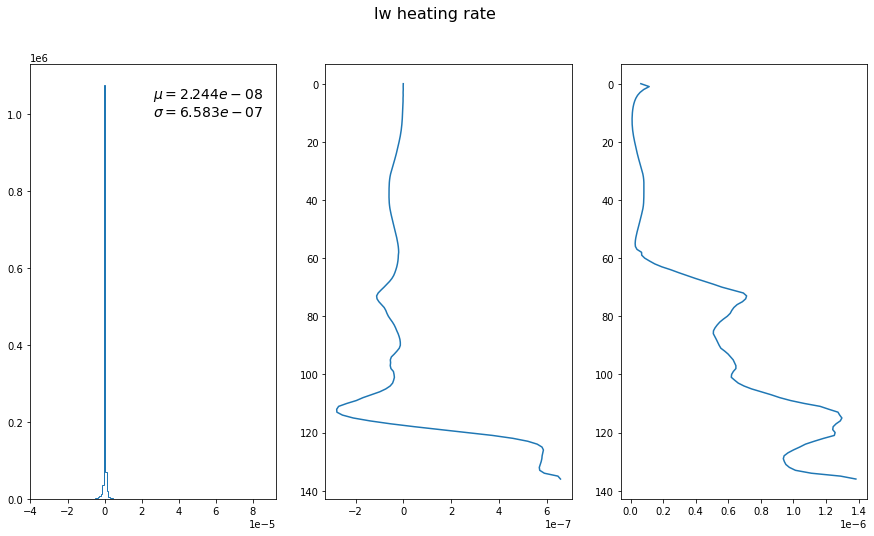

1.3936394e-08 2.7419412e-07


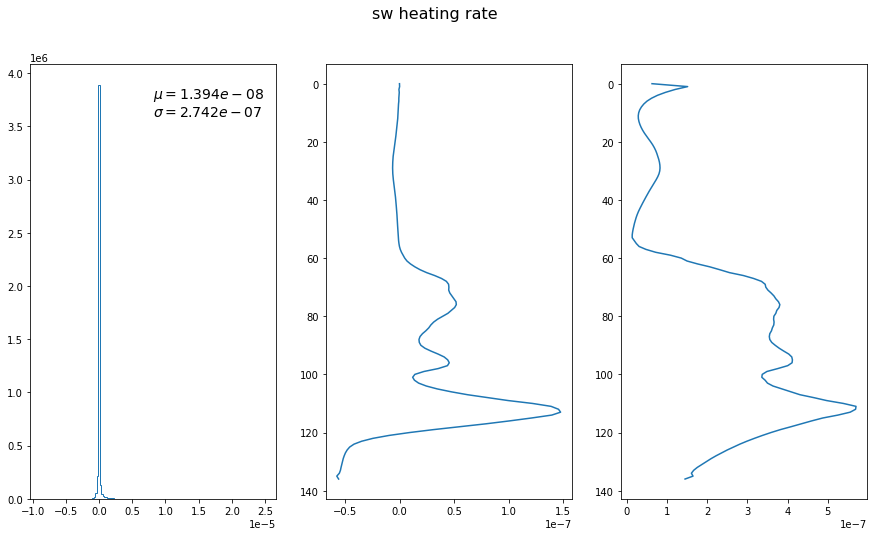

In [21]:
plot_output(np.array(ds.flux_dn_lw), name="Downwards lw flux")
plot_output(np.array(ds.flux_up_lw), name="Upwards lw flux")
plot_output(np.array(ds.flux_dn_sw), name="Downwards sw flux")
plot_output(np.array(ds.flux_up_lw), name="Upwards sw flux")
plot_output(np.array(ds.hr_lw), name="lw heating rate")
plot_output(np.array(ds.hr_sw), name="sw heating rate")